In [ ]:
!pip install pandas_market_calendars
!pip install matplotlib-venn
!apt-get -qq install -y libfluidsynth1
!pip install pmdarima
!pip install statsmodels
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.3/107.3 kB 880.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.1/196.1 kB 4.3 MB/s eta 0:00:00
E: Package 'libfluidsynth1' has no installation candidate
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 4.5 MB/s eta 0:00:00


In [ ]:
!pip install ucimlrepo  # instalamos el paquete específico llamado ucimlrepo para acceder al dataset elegido

## **PUNTO 10:**

*Construir un modelo SARIMA-X con alguna de las series analizadas y elegir un conjunto de variables regresoras X. Realizar los análisis correspondientes.*

Se utiliza la serie C6H6 (benceno) agregandole la variable exogena T (temperatura)


In [ ]:
#función diseñada para facilitar la descarga de datasets de la colección UCI Machine Learning Repository

from ucimlrepo import fetch_ucirepo
import pandas as pd

#Traigo el  dataset
air_quality = fetch_ucirepo(id=360)

#data (as pandas dataframes)
X = air_quality.data.features
y = air_quality.data.targets

# variable information
print(air_quality.variables)

             name     role         type demographic  \
0            Date  Feature         Date        None   
1            Time  Feature  Categorical        None   
2          CO(GT)  Feature      Integer        None   
3     PT08.S1(CO)  Feature  Categorical        None   
4        NMHC(GT)  Feature      Integer        None   
5        C6H6(GT)  Feature   Continuous        None   
6   PT08.S2(NMHC)  Feature  Categorical        None   
7         NOx(GT)  Feature      Integer        None   
8    PT08.S3(NOx)  Feature  Categorical        None   
9         NO2(GT)  Feature      Integer        None   
10   PT08.S4(NO2)  Feature  Categorical        None   
11    PT08.S5(O3)  Feature  Categorical        None   
12              T  Feature   Continuous        None   
13             RH  Feature   Continuous        None   
14             AH  Feature   Continuous        None   

                                          description       units  \
0                                                N

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_market_calendars as mcal
import warnings
warnings.filterwarnings('ignore')

Generamos la base con la variables con las que vamos a trabajar: Date, Time, C6H6(GT), T, RH

In [ ]:
# Crear el DataFrame con todas las características
df_total= air_quality.data.features

#Seleccionar las columnas específicas con las que vamos a trabajar
df = df_total[['Date', 'Time', 'C6H6(GT)', 'T', 'RH']]

# Mostrar el DataFrame resultante
print(df.head())

        Date      Time  C6H6(GT)     T    RH
0  3/10/2004  18:00:00      11.9  13.6  48.9
1  3/10/2004  19:00:00       9.4  13.3  47.7
2  3/10/2004  20:00:00       9.0  11.9  54.0
3  3/10/2004  21:00:00       9.2  11.0  60.0
4  3/10/2004  22:00:00       6.5  11.2  59.6


In [ ]:
# Cambiamos el nombre de la variable C6H6(GT)
df.rename(columns={'C6H6(GT)': 'C6H6'}, inplace=True)

Convertimos la columna Date y Time en indice

In [ ]:
# Creamos columna Datetime combinada
df['Datetime'] = df['Date'] + ' ' + df['Time']

# Intentamos convertir a datetime y capturar el error
# En lugar de poner format='%d/%m/%Y %H:%M:%S' pusimos dayfirst=False para que infiera automaticamente el formato
try:
    df['Datetime'] = pd.to_datetime(df['Datetime'], dayfirst=False)
except ValueError as e:
    print(f"Error al convertir fechas: {e}")

# Mostramos las filas que no se convirtieron correctamente
print(df[pd.to_datetime(df['Datetime'], errors='coerce').isnull()])

# Mostramos las filas que no se convirtieron correctamente para asegurarnos que se convirtió buen
invalid_dates = df[pd.to_datetime(df['Datetime'], errors='coerce').isnull()]
print("Filas con fechas no válidas:")
print(invalid_dates)

Empty DataFrame
Columns: [Date, Time, C6H6, T, RH, Datetime]
Index: []
Filas con fechas no válidas:
Empty DataFrame
Columns: [Date, Time, C6H6, T, RH, Datetime]
Index: []


In [ ]:
# Establecemos la columna datetime como índice
df.set_index('Datetime', inplace=True)

In [ ]:
# Eliminamos las columnas Date y Time
df.drop(['Date', 'Time'], axis=1, inplace=True)

In [ ]:
# Verificamos numero de filas de la serie
num_filas = len(df)
print(num_filas)

9357


In [ ]:
# Visualizamos df
print(df.head())


                     C6H6     T    RH
Datetime                             
2004-03-10 18:00:00  11.9  13.6  48.9
2004-03-10 19:00:00   9.4  13.3  47.7
2004-03-10 20:00:00   9.0  11.9  54.0
2004-03-10 21:00:00   9.2  11.0  60.0
2004-03-10 22:00:00   6.5  11.2  59.6


In [ ]:
# Graficamos las series temporales
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


Variable C6H6


In [ ]:
# Variable C6H6
# Reemplazamos los valores -200 en la columna C6H6 con NaN
df['C6H6'] = df['C6H6'].replace(-200, pd.NA)

# Aplicar forward fill para reemplazar los valores NaN
df['C6H6'].fillna(method='ffill', inplace=True)

In [ ]:
# Variable T
# Reemplazamos los valores -200 en la columna T con NaN
df['T'] = df['T'].replace(-200, pd.NA)

# Aplicar forward fill para reemplazar los valores NaN
df['T'].fillna(method='ffill', inplace=True)

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [ ]:
import pmdarima as pm

In [ ]:
# Diferenciación regular d=24 hora de C6H6 transformado
df_C6H6_24 = df['C6H6'].diff(24).dropna()
print(len(df_C6H6_24))

9333


In [ ]:
from scipy.stats import jarque_bera, shapiro, boxcox, probplot


In [ ]:
#Renombramos para unificar nombres
df_C6H6 = df['C6H6']  #serie original
df_C6H6_24 = df_C6H6_24 #serie diferenciada 24 hs

df_T = df['T']

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss
from numpy import log

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
#modelo2 (2,0,2)(1,1,1,24)
modelo2 = SARIMAX(df_C6H6, order=(2,0,2), seasonal_order=(1,1,1,24))
modelo2_fit = modelo2.fit()
print(modelo2_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                 C6H6   No. Observations:                 9357
Model:             SARIMAX(2, 0, 2)x(1, 1, [1], 24)   Log Likelihood              -23864.895
Date:                              Sat, 06 Jul 2024   AIC                          47743.790
Time:                                      20:03:49   BIC                          47793.779
Sample:                                  03-10-2004   HQIC                         47760.769
                                       - 04-04-2005                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5693      0.023     68.350      0.000       1.524       1.614
ar.L2         -0.58

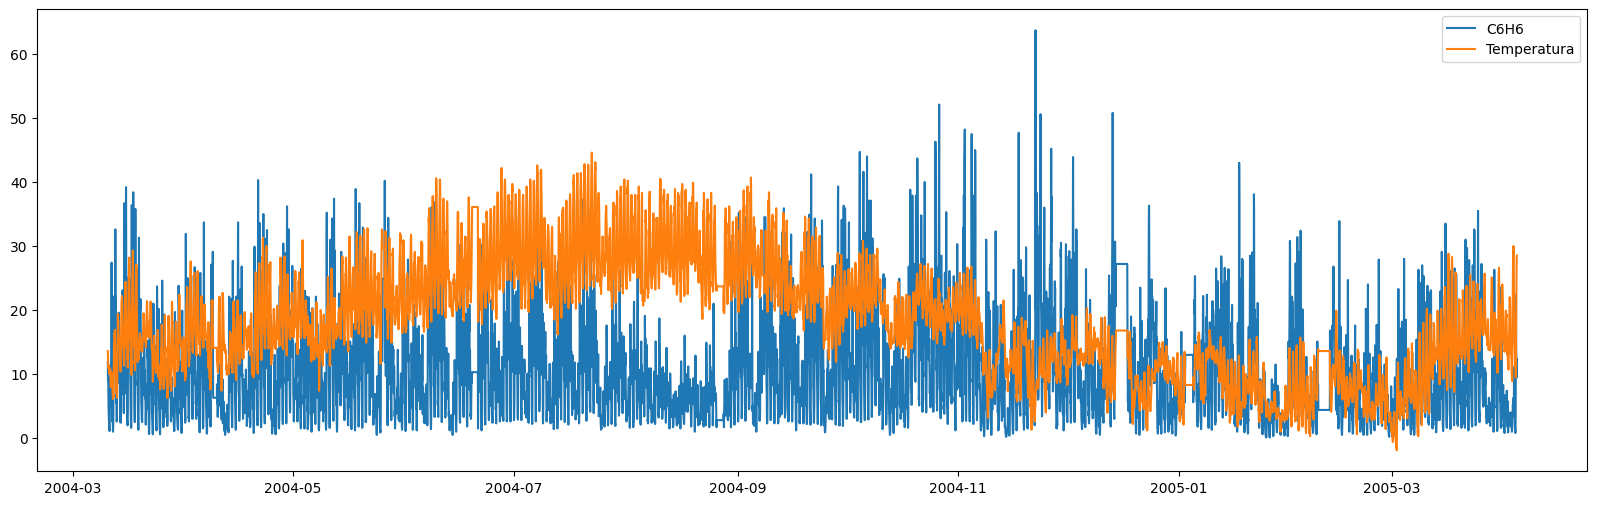

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(df_C6H6, label='C6H6')
plt.plot(df_T, label='Temperatura')
plt.legend()
plt.show()


In [ ]:
# Separacion Train/Test la serir df_C6H6, 80% y 20%

df_C6H6_train = df_C6H6.iloc[:round(len(df_C6H6)*.8)]
df_C6H6_test = df_C6H6.iloc[round(len(df_C6H6)*.8):]

# Corroboramos que los limites se hayan establecido segun lo planificado
print(df_C6H6_train, df_C6H6_test)

Datetime
2004-03-10 18:00:00    11.9
2004-03-10 19:00:00     9.4
2004-03-10 20:00:00     9.0
2004-03-10 21:00:00     9.2
2004-03-10 22:00:00     6.5
                       ... 
2005-01-16 11:00:00     2.6
2005-01-16 12:00:00     2.2
2005-01-16 13:00:00     3.0
2005-01-16 14:00:00     1.9
2005-01-16 15:00:00     2.0
Name: C6H6, Length: 7486, dtype: float64 Datetime
2005-01-16 16:00:00     2.8
2005-01-16 17:00:00     3.3
2005-01-16 18:00:00     3.4
2005-01-16 19:00:00     7.1
2005-01-16 20:00:00     7.4
                       ... 
2005-04-04 10:00:00    13.5
2005-04-04 11:00:00    11.4
2005-04-04 12:00:00    12.4
2005-04-04 13:00:00     9.5
2005-04-04 14:00:00    11.9
Name: C6H6, Length: 1871, dtype: float64


In [ ]:
# Separacion Train/Test la serir df_T, 80% y 20%

df_T_train = df_T.iloc[:round(len(df_T)*.8)]
df_T_test = df_T.iloc[round(len(df_T)*.8):]

# Corroboramos que los limites se hayan establecido segun lo planificado
print(df_T_train, df_T_test)

Datetime
2004-03-10 18:00:00    13.6
2004-03-10 19:00:00    13.3
2004-03-10 20:00:00    11.9
2004-03-10 21:00:00    11.0
2004-03-10 22:00:00    11.2
                       ... 
2005-01-16 11:00:00    10.7
2005-01-16 12:00:00    11.1
2005-01-16 13:00:00    11.9
2005-01-16 14:00:00    11.4
2005-01-16 15:00:00    11.3
Name: T, Length: 7486, dtype: float64 Datetime
2005-01-16 16:00:00    11.0
2005-01-16 17:00:00    10.3
2005-01-16 18:00:00     8.4
2005-01-16 19:00:00     8.3
2005-01-16 20:00:00     8.1
                       ... 
2005-04-04 10:00:00    21.9
2005-04-04 11:00:00    24.3
2005-04-04 12:00:00    26.9
2005-04-04 13:00:00    28.3
2005-04-04 14:00:00    28.5
Name: T, Length: 1871, dtype: float64


In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import ccf

In [ ]:
C6H6_array = df_C6H6_train.values
T_array = df_T_train.values

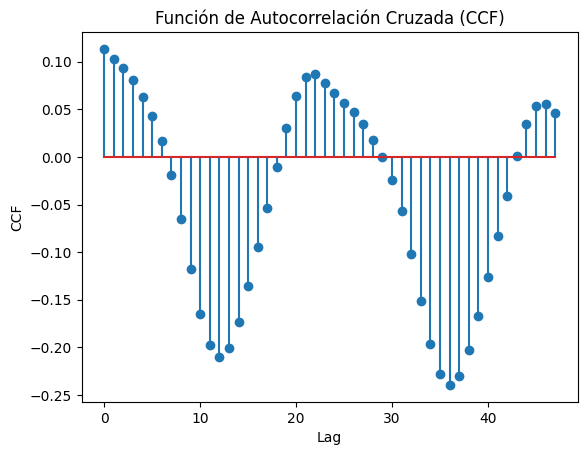

In [ ]:
# Calculo de CCF
lags = 48
cross_corr = ccf(C6H6_array, T_array)[:lags]

# Grafico de CCF
plt.stem(range(lags), cross_corr, use_line_collection=True)
plt.title('Función de Autocorrelación Cruzada (CCF)')
plt.xlabel('Lag')
plt.ylabel('CCF')
plt.show()

hay ciertos lags específicos donde las series C6H6 y T están correlacionadas, tanto positiva como negativamente.

Lags cercanos a 0: una correlación positiva en los lags cercanos a 0 indica que, en el mismo momento o con un pequeño desfase temporal, cuando la temperatura aumenta, la concentración de benceno también tiende a aumentar. Esto sugiere una relación directa y casi inmediata entre la temperatura y la concentración de benceno.

Lags positivos: Una correlación positiva en los lags positivos significa que un aumento en la temperatura predice un aumento en la concentración de benceno después de cierto tiempo. Por ejemplo, si hay una correlación positiva en el lag 5, esto implica que un aumento en la temperatura ahora podría resultar en un aumento en la concentración de benceno después de 5 horas.

Lags negativos: Una correlación negativa en los lags negativos indica que un aumento en la temperatura (T) en el pasado está asociado con una disminución en la concentración de benceno (C6H6) en el presente.


In [ ]:
# Ahora armo el modelo SARIMAX con variable endogena

modelo_sarimax = sm.tsa.SARIMAX(df_C6H6_train, order=(2,0,2), seasonal_order=(1,1,1,24), exog=df_T_train)
resultado_sarimax = modelo_sarimax.fit()

print(resultado_sarimax.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                                 C6H6   No. Observations:                 7486
Model:             SARIMAX(2, 0, 2)x(1, 1, [1], 24)   Log Likelihood              -19247.046
Date:                              Sun, 07 Jul 2024   AIC                          38510.092
Time:                                      20:36:53   BIC                          38565.433
Sample:                                  03-10-2004   HQIC                         38529.101
                                       - 01-16-2005                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T              0.0198      0.025      0.802      0.423      -0.029       0.068
ar.L1          1.57

Los coeficinetes son significativos pero los residuos no cumplen con normalidad ni homocedasticidad.

In [ ]:
from statsmodels.tsa.stattools import acf, pacf

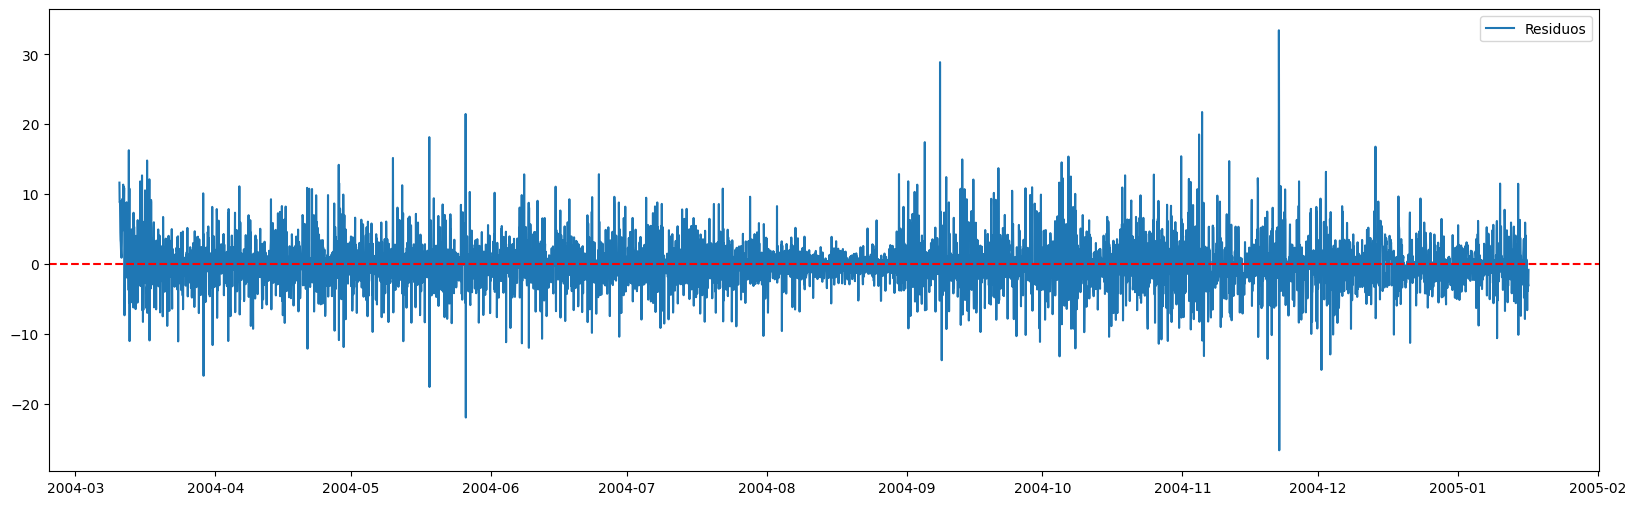

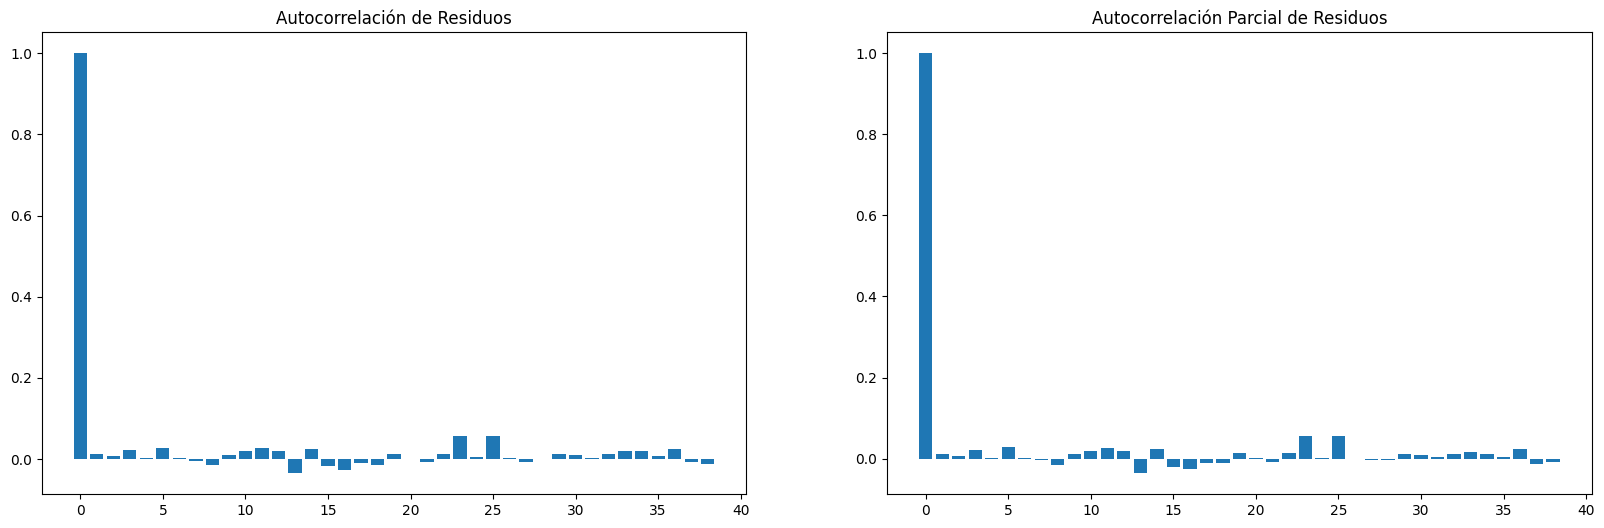

      lb_stat     lb_pvalue
24  76.991855  1.820762e-07


In [ ]:
# Obtener los residuos del modelo SARIMAX
residuos = resultado_sarimax.resid

plt.figure(figsize=(20, 6))
plt.plot(residuos, label='Residuos')
plt.axhline(0, color='r', linestyle='--')
plt.legend()
plt.show()

acf_residuos = acf(residuos, fft=False)
pacf_residuos = pacf(residuos)

plt.figure(figsize=(20, 6))
plt.subplot(121)
plt.bar(range(len(acf_residuos)), acf_residuos)
plt.title('Autocorrelación de Residuos')
plt.subplot(122)
plt.bar(range(len(pacf_residuos)), pacf_residuos)
plt.title('Autocorrelación Parcial de Residuos')
plt.show()

ljung_box = sm.stats.acorr_ljungbox(residuos, lags=[24], return_df=True)
print(ljung_box)


Con 24 lag el p-valor 0 < 0.05 por lo que se constata que no cumple normalidad

Text(0, 0.5, 'P-valores ')

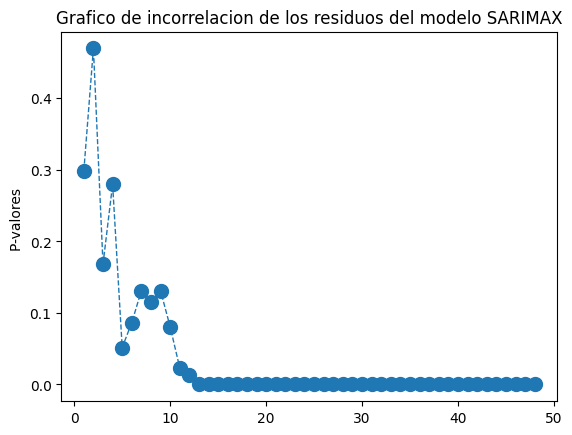

In [ ]:
Incorr_residuos_modelo_SARIMAX=sm.stats.acorr_ljungbox(resultado_sarimax.resid, lags=48)
plt.plot(Incorr_residuos_modelo_SARIMAX.lb_pvalue, marker='o', markersize=10, linestyle='--', linewidth=1)
plt.title("Grafico de incorrelacion de los residuos del modelo SARIMAX")
plt.ylabel("P-valores ")

In [ ]:
import statsmodels.api as sm
from scipy.stats import chi2

In [ ]:
#
lags = 24
acf_values = sm.tsa.acf(residuos, nlags=lags, fft=False)

#Calculamos el estadistico de prueba Q de Box-Pierce
n = len(residuos)
Q = n * np.sum(np.square(acf_values[1:lags+1]))
p_value = 1 - chi2.cdf(Q, df=lags)

print(f'Estadística de prueba (Q): {Q:.4f}')
print(f'Valor p: {p_value:.4f}')
alpha = 0.05
if p_value < alpha:
    print("Se rechaza la hipótesis nula: hay autocorrelación significativa en los residuos.")
else:
    print("No se rechaza la hipótesis nula: no hay autocorrelación significativa en los residuos.")

Estadística de prueba (Q): 76.8155
Valor p: 0.0000
Se rechaza la hipótesis nula: hay autocorrelación significativa en los residuos.


In [ ]:
print(len(df_T_test))

1871


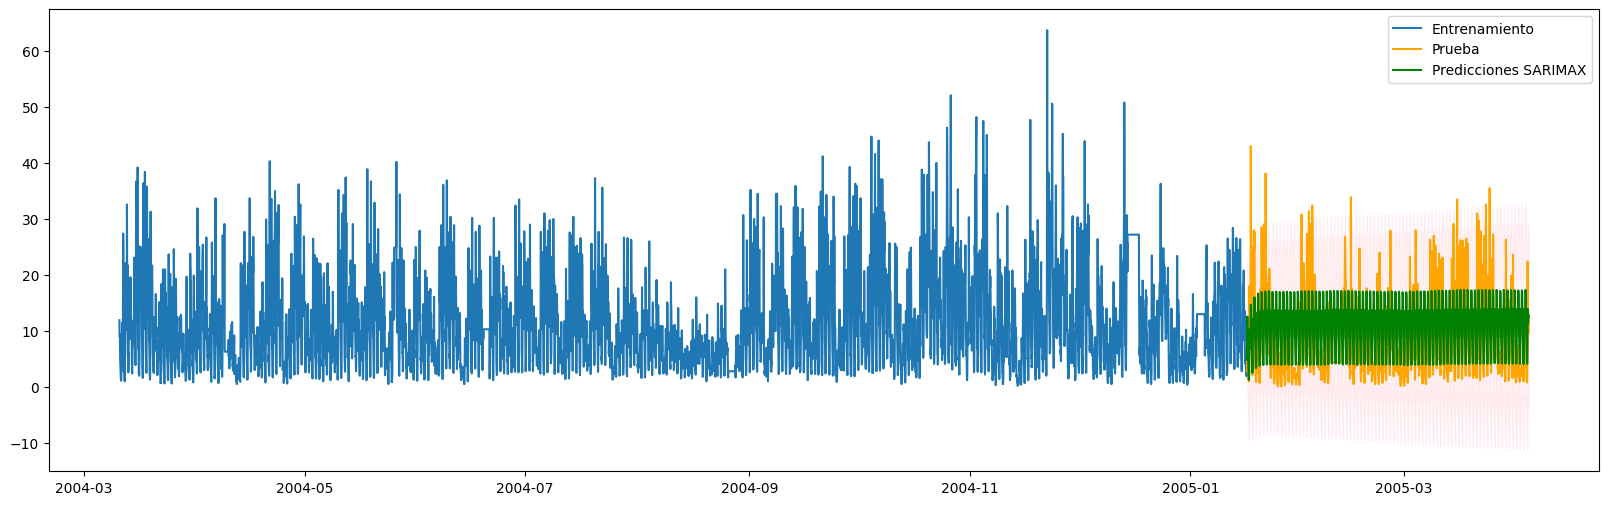

In [ ]:
# Predicciones del modelo SARIMAX
pred_sarimax = resultado_sarimax.get_forecast(steps=1871, exog=df_T_test)
#pred_sarimax = resultado_sarimax.get_forecast(steps=24, exog=test[['MediaIngresosdestino2.1']])

pred_conf_int_sarimax = pred_sarimax.conf_int()


plt.figure(figsize=(20, 6))
plt.plot(df_C6H6_train.index, df_C6H6_train, label='Entrenamiento')
plt.plot(df_C6H6_test.index, df_C6H6_test, label='Prueba', color='orange')
plt.plot(df_C6H6_test.index, pred_sarimax.predicted_mean, label='Predicciones SARIMAX', color='green')
plt.fill_between(df_C6H6_test.index, pred_conf_int_sarimax.iloc[:, 0], pred_conf_int_sarimax.iloc[:, 1], color='pink', alpha=0.2)
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Métricas para el modelo SARIMAX
mse_sarimax = mean_squared_error(df_C6H6_test, pred_sarimax.predicted_mean)
rmse_sarimax = np.sqrt(mse_sarimax)
mae_sarimax = mean_absolute_error(df_C6H6_test, pred_sarimax.predicted_mean)
mape_sarimax = np.mean(np.abs((df_C6H6_test- pred_sarimax.predicted_mean) / df_C6H6_test)) * 100

print(f'Métricas SARIMAX:\nMSE: {mse_sarimax}\nRMSE: {rmse_sarimax}\nMAE: {mae_sarimax}\nMAPE: {mape_sarimax}')

Métricas SARIMAX:
MSE: 37.75492951106133
RMSE: 6.1445040085479095
MAE: 4.993449312031198
MAPE: 146.55130681581272


**Comparativos metricas de distintos modelos**


##**PUNTO 11:**

*En caso de presentar estacionalidad alguna de las series elegidas, se solicita determinar la representación más adecuada mediante algún modelo SARIMA y comparar los resultados con los modelos determinados en el trabajo anterior.*

Esto fue realizado en el punto 5.

*(Opcional) Realizar la prueba de hipótesis de HEGY para testear la conjetura de raíz unitaria sobre las series elegidas.*


La prueba HEGY (Hylleberg, Engle, Granger y Yoo) se utiliza para detectar raíces unitarias estacionales en series temporales. Es una extensión de las pruebas de raíces unitarias convencionales (como la prueba de Dickey-Fuller aumentada) y está diseñada para series con datos trimestrales o mensuales, donde se pueden detectar raíces unitarias en diferentes frecuencias estacionales.

La idea principal de la prueba HEGY es descomponer la serie temporal en componentes que correspondan a diferentes frecuencias estacionales y luego realizar pruebas de raíces unitarias en cada uno de estos componentes.

Pasos principales para realizar la prueba HEGY:
Transformación de la serie temporal: La serie original se transforma en componentes estacionales utilizando polinomios estacionales.
Regresión auxiliar: Se estima una regresión que incluye las variables transformadas y se realiza la prueba de raíces unitarias en cada componente.
Interpretación de resultados: Se analizan los resultados de las pruebas para determinar si hay raíces unitarias estacionales en la serie temporal.

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.tsatools import lagmat
from statsmodels.tsa.stattools import adfuller


In [ ]:
# Descomposición de la serie temporal usando STL
stl = STL(df_C6H6, seasonal=25)
result = stl.fit()
seasonal, trend, resid = result.seasonal, result.trend, result.resid
#el test no permite 24 por eso se toma 25

In [ ]:
# Variables auxiliares
n = len(df_C6H6)
time = np.arange(1, n + 1)
d = pd.DataFrame({'y': df_C6H6})
for i in range(1, 25):
    d[f'y{i}'] = df_C6H6.shift(i)
d = d.dropna()


In [ ]:
# Regresión auxiliar
y = d['y']
X = d[[f'y{i}' for i in range(1, 25)]]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Prueba de raíces unitarias
adf_result = adfuller(model.resid)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
for key, value in adf_result[4].items():
    print(f'Critical Value ({key}):', value)


ADF Statistic: -16.84107343391112
p-value: 1.1379926472091072e-29
Critical Value (1%): -3.4310537231669236
Critical Value (5%): -2.861851001180975
Critical Value (10%): -2.5669355408505097


Interpretación:
p-value:
El valor p es 1.1379926472091072e-29, que es extremadamente pequeño (prácticamente cero). Esto sugiere que hay una evidencia muy significativa para rechazar la hipótesis nula de que los residuos tienen raíces unitarias. En otras palabras, los residuos son estacionarios.

